## Reactive SINDy with Tellurium

### Solve a Reactive SINDy model, using simulated data using Tellurium & stoichiometry matrix, and Elastic net from Scikit-learn package

In [1]:
import numpy as np
import pandas as pd
from scipy import ndimage
from sklearn.linear_model import ElasticNet
import tellurium as te
import roadrunner
import matplotlib.pyplot as plt

### Generate data

In [2]:
r = te.loada('''
  v1: Y -> 2Y; 1.0*Y;
  v2: P + Y -> 2P; 0.01*P*Y;
  v3: P -> ; 0.3*P;
  
  // Initialization
  Y = 100;
  P = 50;
''')

In [3]:
END_TIME = 15
m = r.simulate (0, END_TIME, 200)
# m = r.simulate (0, 70, 2000)

In [4]:
m_df = pd.DataFrame(m, columns=['time', 'y', 'p'])
print(m_df.shape)
m_df.head()

(200, 3)


,time,y,p
0,0.000000,100.000000,50.000000
1,0.075377,103.733676,52.783686
2,0.150754,107.368932,55.877299
3,0.226131,110.858378,59.311525
4,0.301508,114.149948,63.118052


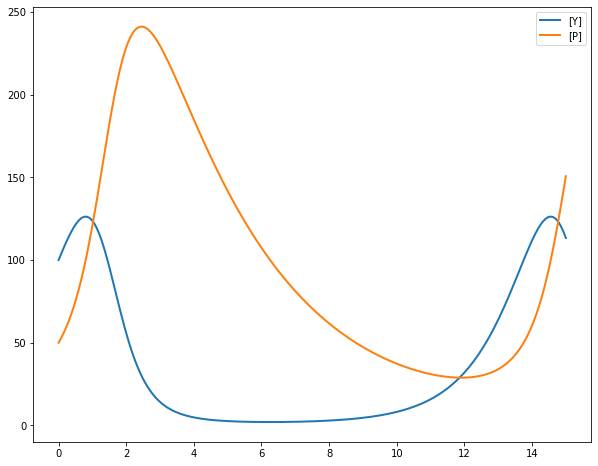

In [5]:
r.plot(figsize=(10,8))

In [6]:
r.getFullStoichiometryMatrix()

     v1, v2, v3
Y [[  1, -1,  0],
P  [  0,  1, -1]]

### Approximate the derivatives dX/dt

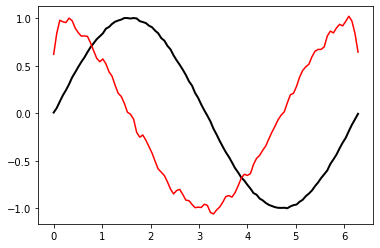

In [7]:
# In principle, authors used second-order finite difference
# to approximate dX/dt.

# For quick computation I used the below code provided below:
# https://stackoverflow.com/questions/18991408/python-finite-difference-functions

x = np.linspace(0,2*np.pi,100)
f = np.sin(x) + .02*(np.random.rand(100)-.5)
#Normalization:
dx = x[1] - x[0] # use np.diff(x) if x is not uniform

#First derivatives:
df = np.diff(f) / dx
cf = np.convolve(f, [1,-1]) / dx
gf = ndimage.gaussian_filter1d(f, sigma=1, order=1, mode='wrap') / dx

plt.plot(x, f, 'k', lw=2, label='original')
plt.plot(x, gf, 'r', label='gf')

In [8]:
# Now used the same method to m_df
m_df.head()

,time,y,p
0,0.000000,100.000000,50.000000
1,0.075377,103.733676,52.783686
2,0.150754,107.368932,55.877299
3,0.226131,110.858378,59.311525
4,0.301508,114.149948,63.118052


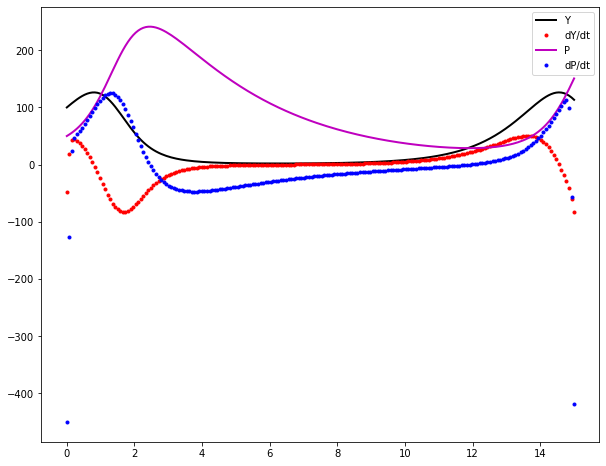

In [9]:
plt.figure(figsize=(10, 8))
t = m_df['time']
y = m_df['y']
p = m_df['p']

dt = t[1] - t[0] # use np.diff(x) if x is not uniform
#First derivatives:
dy = np.diff(y) / dt
cy = np.convolve(y, [1,-1]) / dt
gy = ndimage.gaussian_filter1d(y, sigma=1, order=1, mode='wrap') / dt

dp = np.diff(p) / dt
cp = np.convolve(p, [1,-1]) / dt
gp = ndimage.gaussian_filter1d(p, sigma=1, order=1, mode='wrap') / dt

plt.plot(t, y, 'k', lw=2, label='Y')
plt.plot(t, gy, 'r.', label='dY/dt')
plt.plot(t, p, 'm', lw=2, label='P')
plt.plot(t, gp, 'b.', label='dP/dt')
plt.legend()

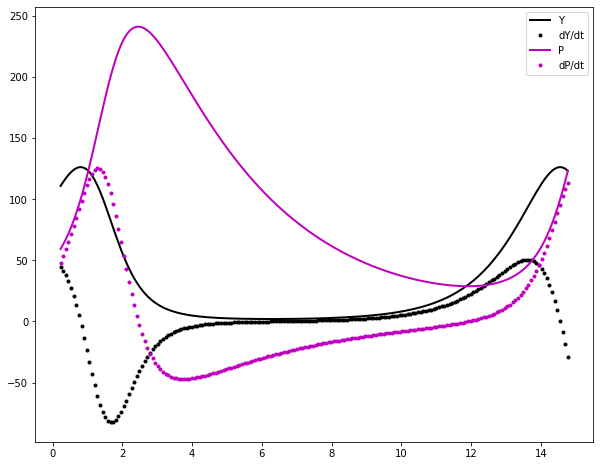

In [10]:
# without boundary values... :) 
plt.figure(figsize=(10, 8))
plt.plot(t[3:-3], y[3:-3], 'k', lw=2, label='Y')
plt.plot(t[3:-3], gy[3:-3], 'k.', label='dY/dt')
plt.plot(t[3:-3], p[3:-3], 'm', lw=2, label='P')
plt.plot(t[3:-3], gp[3:-3], 'm.', label='dP/dt')
plt.legend()

### Get the Ansatz reaction matrix

In [11]:
# below is used to generate stoichiometry matrix for all possible reactions
ansatz_r = te.loada('''
    r0: 2Y -> ; 
    r1: 2P -> ; 
    r2: Y -> 2Y; 
    r3: Y + P -> 2P; 
    r4: P -> ; 
    r5: Y + P -> 2Y; 
    r6: Y -> ; 
    r7: 2P -> P; 
    r8: P -> 2P; 
    r9: 2Y -> Y; 
    r10: Y + P -> Y; 
    r11: Y + P -> P; 
    r12: 2Y -> P; 
    r13: Y -> P; 
    r14: P -> Y; 
    r15: Y -> 2P; 
''')

In [12]:
ansatz_mat = ansatz_r.getFullStoichiometryMatrix()

In [13]:
# stoichiometry matrix
pd.DataFrame(ansatz_mat,
             columns=['r'+str(num) for num in range(16)],
             index=['Y', 'P'])

,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15
Y,-2.0,0.0,1.0,-1.0,0.0,1.0,-1.0,0.0,0.0,-1.0,0.0,-1.0,-2.0,-1.0,1.0,-1.0
P,0.0,-2.0,0.0,1.0,-1.0,-1.0,0.0,-1.0,1.0,0.0,-1.0,0.0,1.0,1.0,-1.0,2.0


In [14]:
# for demo
demo_concentrations = ['[Y][Y]',
                       '[P][P]',
                       '[Y]',
                       '[Y][P]',
                       '[P]',
                       '[Y][P]',
                       '[Y]',
                       '[P][P]',
                       '[P]',
                       '[Y][Y]',
                       '[Y][P]',
                       '[Y][P]',
                       '[Y][Y]',
                       '[Y]',
                       '[P]',
                       '[Y]',
                      ]
concen_form_df = pd.DataFrame(demo_concentrations,
                              index=['r'+str(num) for num in range(16)],
                              columns=['concentration']).T

In [15]:
# e.g., ansatz_mat[Y] is stoichiometry coefficients of Y
ansatz_mat['Y']

array([-2.,  0.,  1., -1.,  0.,  1., -1.,  0.,  0., -1.,  0., -1., -2.,
       -1.,  1., -1.])

In [16]:
ansatz_mat['P']

array([ 0., -2.,  0.,  1., -1., -1.,  0., -1.,  1.,  0., -1.,  0.,  1.,
        1., -1.,  2.])

### Prepare data

In [17]:
# Prepare predictor matrix/outcome vector using
# 1. concentrations (product of reactants) of ansatz reactions, 
# 2. dX/dt estimates in order.

In [18]:
def getAnsatzConcentrations(y, p):
  return np.array([y**2,
                   p**2,
                   y,
                   y*p,
                   p,
                   y*p,
                   y,
                   p**2,
                   p,
                   y**2,
                   y*p,
                   y*p,
                   y**2,
                   y,
                   p,
                   y])

In [19]:
# Remove a few bdry values from both ends
eval_y = y[3:-3]
eval_p = p[3:-3]
eval_dy = gy[3:-3]
eval_dp = gp[3:-3]

# Get predictor data. Basically concentration *(element-wise product) stoichiometry coefficient.  
# For both concentration of (Y, P) at time T and derivative of them (Y, P) at time T
obs_y = np.vstack([getAnsatzConcentrations(val[0], val[1])*ansatz_mat['Y'] for val in zip(eval_y, eval_p)])
obs_p = np.vstack([getAnsatzConcentrations(val[0], val[1])*ansatz_mat['P'] for val in zip(eval_y, eval_p)])
print(obs_y.shape)
print(obs_p.shape)

(194, 16)
(194, 16)


In [20]:
full_x = np.concatenate((obs_y, obs_p), axis=0)
full_y = np.concatenate((eval_dy, eval_dp), axis=0)
print(full_x.shape)
print(full_y.shape)

(388, 16)
(388,)


### Fit the Elastic Net model (pos & neg coefficients)

In [21]:
# fit Elastic net. 
# Below hyperparameters were given in the Reactive SINDy paper
enet = ElasticNet(alpha=2.7e-7, l1_ratio=1.0, max_iter=50000)
enet_fit = enet.fit(full_x, full_y)

In [22]:
np.round(enet_fit.coef_, 2)

array([-0.  ,  0.  ,  0.21,  0.01,  0.28, -0.  , -0.75, -0.  , -0.02,
        0.  , -0.  ,  0.  , -0.  , -0.1 , -0.  ,  0.06])

In [23]:
recovered_r = te.loada('''
    r2: Y -> 2Y; 0.21*Y;
    r3: Y + P -> 2P; 0.01*Y*P;
    r4: P -> ; 0.28*P;

    r6: Y -> ; -0.75*Y;

    r8: P -> 2P; -0.02*P;

    r13: Y -> P; -0.1*Y;

    r15: Y -> 2P; 0.06*Y;
    
    // Initialization here
    Y = 100;
    P = 50;
''')
# recovered_r = te.loada('''
#     r2: Y -> 2Y; 0.19*Y;
#     r3: Y + P -> 2P; 0.01*Y*P;
#     r4: P -> ; 0.28*P;

#     r6: Y -> ; -0.77*Y;

#     r8: P -> 2P; -0.02*P;

#     r13: Y -> P; -0.1*Y;

#     r15: Y -> 2P; 0.06*Y;
    
#   // Initialization here
#   Y = 100;
#   P = 50;
# ''')

In [24]:
recovered_m = recovered_r.simulate (0, END_TIME, 200)

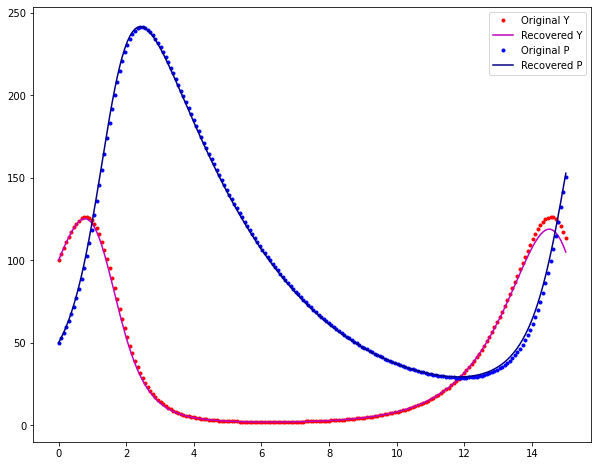

In [25]:
plt.figure(figsize=(10, 8))
m_times = m['time']
plt.plot(m_times, m[:,1], 'r.', lw=2, label='Original Y')
plt.plot(m_times, recovered_m[:,1], 'm', label='Recovered Y')
plt.plot(m_times, m[:,2], 'b.', lw=2, label='Original P')
plt.plot(m_times, recovered_m[:,2], 'navy', label='Recovered P')

plt.legend()

In [26]:
# Works well!
# even though the exact rate constants are different, and some are even negative 

### Fit the Elastic Net model (positive only)

In [27]:
pos_enet = ElasticNet(alpha=2.7e-2, l1_ratio=1.0, max_iter=50000, positive=True)
pos_enet_fit = pos_enet.fit(full_x, full_y)

In [28]:
pos_enet_fit.coef_

array([3.56154067e-07, 0.00000000e+00, 1.00159631e+00, 9.95214172e-03,
       2.98491507e-01, 1.77960527e-06, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.96532198e-05, 1.24038447e-05, 0.00000000e+00,
       2.99024967e-06, 0.00000000e+00, 0.00000000e+00, 1.74055768e-03])

In [29]:
np.round(pos_enet_fit.coef_, 2)

array([0.  , 0.  , 1.  , 0.01, 0.3 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [30]:
pd.DataFrame(zip(pos_enet_fit.coef_, np.round(pos_enet_fit.coef_, 2)),
             columns=['original', 'rounded_2'],
             index=['k'+str(val) for val in range(16)])

,original,rounded_2
k0,3.561541e-07,0.00
k1,0.000000e+00,0.00
k2,1.001596e+00,1.00
k3,9.952142e-03,0.01
k4,2.984915e-01,0.30
k5,1.779605e-06,0.00
k6,0.000000e+00,0.00
k7,0.000000e+00,0.00
k8,0.000000e+00,0.00
k9,3.965322e-05,0.00


### **After rounding, all three coefficients were accurately recovered

## When data were partially observed

v1: Y -> 2Y; 1.0\*Y

v2: P + Y -> 2P; 0.01\*P\*Y

v3: P -> ; 0.3\*P

In [31]:
# If only observations for dY/dt were used
y_pos_enet = ElasticNet(alpha=2.7e-7, l1_ratio=1.0, max_iter=50000, positive=True)
y_pos_enet_fit = y_pos_enet.fit(obs_y, eval_dy)
np.round(y_pos_enet_fit.coef_, 2)

array([0.  , 0.  , 1.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  ])

In [32]:
recovered_r_y = te.loada('''
    r2: Y -> 2Y; 1.0*Y;
    r3: Y + P -> 2P; 0.01*Y*P;
    r4: P -> ; 0.0*P;
    Y = 100;
    P = 50;
''')
recovered_m_y = recovered_r_y.simulate (0, END_TIME, 200)

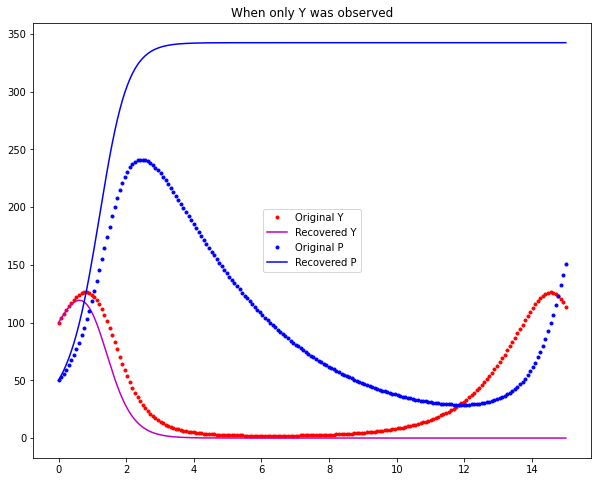

In [33]:
plt.figure(figsize=(10, 8))
m_times = m['time']
plt.plot(m_times, m[:,1], 'r.', lw=2, label='Original Y')
plt.plot(m_times, recovered_m_y[:,1], 'm', label='Recovered Y')
plt.plot(m_times, m[:,2], 'b.', lw=2, label='Original P')
plt.plot(m_times, recovered_m_y[:,2], 'b', label='Recovered P')
plt.title("When only Y was observed")
plt.legend()

In [34]:
# If only observations for dP/dt were used
p_pos_enet = ElasticNet(alpha=2.7e-7, l1_ratio=1.0, max_iter=50000, positive=True)
p_pos_enet_fit = p_pos_enet.fit(obs_p, eval_dp)
np.round(p_pos_enet_fit.coef_, 2)

array([0.  , 0.  , 0.  , 0.01, 0.3 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.01, 0.  , 0.  ])

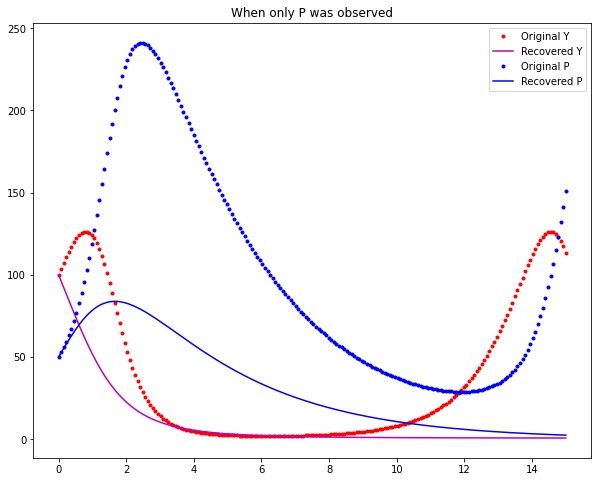

In [35]:
recovered_r_p = te.loada('''
    r2: Y -> 2Y; 0.0*Y;
    r3: Y + P -> 2P; 0.01*Y*P;
    r4: P -> ; 0.3*P;
    Y = 100;
    P = 50;
''')
recovered_m_p = recovered_r_p.simulate (0, END_TIME, 200)
plt.figure(figsize=(10, 8))
m_times = m['time']
plt.plot(m_times, m[:,1], 'r.', lw=2, label='Original Y')
plt.plot(m_times, recovered_m_p[:,1], 'm', label='Recovered Y')
plt.plot(m_times, m[:,2], 'b.', lw=2, label='Original P')
plt.plot(m_times, recovered_m_p[:,2], 'b', label='Recovered P')
plt.title("When only P was observed")
plt.legend()